In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting, dk_roi_viz

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [35]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models')
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup')
images_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/img')

In [36]:
# What type of data do we want?
fs_var = 'ThickAvg'     #["ThickAvg", "ThickStd", "SurfArea", "GrayVol", "ICVol", "ICMean", "ICStd"]
transformation = 'no'   #['no', 'zscore', 'scale']

In [37]:
# Create the directory with results
nm_dir = os.path.join(models_dir, fs_var+'_'+transformation)
os.makedirs(nm_dir, exist_ok=True)

# Load the appropriate data
if 'IC' in fs_var:
    data_final = pd.read_csv(os.path.join(bdata_dir, 'all_data_ThickAvg.txt'), sep=' ', index_col=0)
else:
    data_final = pd.read_csv(os.path.join(bdata_dir, 'all_data_'+fs_var+'.txt'), sep=' ', index_col=0)


In [9]:
# Prepare the data 
cov_norm, cov_pat, feat_norm, feat_pat = prepare_data(data_final, transformation, nm_dir, features=fs_var)

Scaling applied


In [10]:
# Train the model
os.chdir(nm_dir)
if not os.path.isfile(os.path.join(nm_dir,'Z_estimate.txt')): 
    pcn.normative.estimate(covfile = os.path.join(nm_dir,'cov_norm.txt'),
                        respfile = os.path.join(nm_dir,'feat_norm.txt'),
                        cvfolds = 10,
                        alg = 'gpr') #outputsuffix = '_10fold'

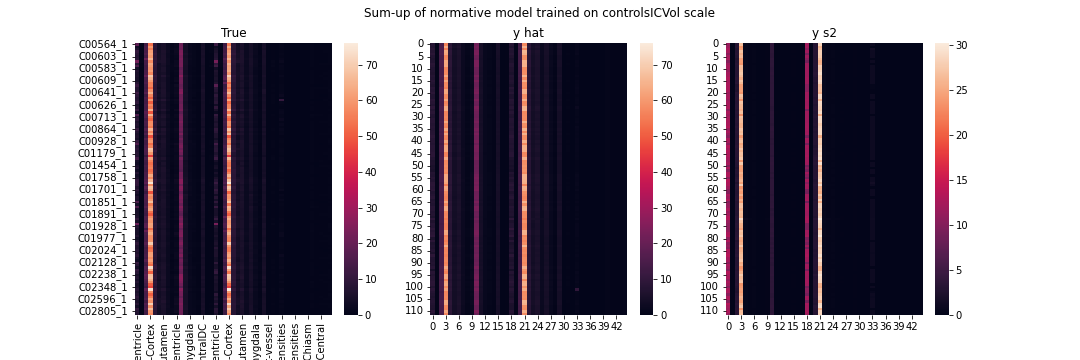

In [11]:
yhat = pd.read_csv(os.path.join(nm_dir,'yhat_estimate.txt'), sep=' ', header=None)
ys2 = pd.read_csv(os.path.join(nm_dir,'ys2_estimate.txt'), sep=' ', header=None)

rtop = np.ceil(np.max([feat_norm.max().max(),yhat.max().max()]))

fig, axes = plt.subplots(1,3,figsize=(15, 5))
sns.heatmap(data=feat_norm, ax=axes[0], cbar=True, cmap='rocket', vmin=0, vmax=rtop)
axes[0].set_title('True')
sns.heatmap(data=yhat, ax=axes[1], cbar=True, cmap='rocket', vmin=0, vmax=rtop)
axes[1].set_title('y hat')
sns.heatmap(data=ys2, ax=axes[2], cbar=True, cmap='rocket')
axes[2].set_title('y s2')
fig.suptitle('Sum-up of normative model trained on controls'+fs_var + ' ' + transformation)

fig.savefig(os.path.join(images_dir, ('02_heat_controls' + fs_var + '_'+transformation+'.png')))

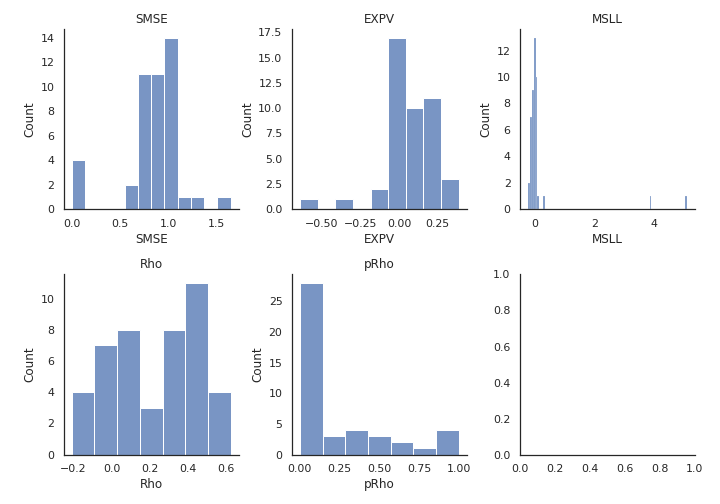

In [12]:
# Load and plot quality measures
nmeasures = plot_quality(nm_dir, save_img = True, fs_var = fs_var, images_dir = images_dir, transformation = transformation)

In [47]:
# Extreme positive deviations of controls
z_estimate = pd.read_csv(os.path.join(nm_dir,'Z_estimate.txt'), header=None, delimiter=' ')

pk = dk_roi_viz(nm_dir, z_estimate, 2, 'pos', fs_var)

if 'IC' in fs_var:
    plot_subcortical(array_name=pk, size=(800, 400),
                 cmap='Spectral_r', color_bar=True,
                 interactive=False,
                 embed_nb=True,
                 screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'04_3d_controls_pos_'+fs_var+'_'+transformation+'.png'))
else:
    plot_cortical(array_name=pk, surface_name="fsa5", size=(800, 400),
                cmap='Spectral_r', color_bar=True,
                interactive=False,
                embed_nb=True,
                screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'04_3d_controls_pos_'+fs_var+'_'+transformation+'.png'))


In [48]:
# Extreme negative deviations of controls
z_estimate = pd.read_csv(os.path.join(nm_dir,'Z_estimate.txt'), header=None, delimiter=' ')

pk = dk_roi_viz(nm_dir, z_estimate, 2, 'neg', fs_var)

if 'IC' in fs_var:
    plot_subcortical(array_name=pk, size=(800, 400),
                 cmap='Spectral_r', color_bar=True,
                 interactive=False,
                 embed_nb=True,
                 screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'04_3d_controls_neg_'+fs_var+'_'+transformation+'.png'))
else:
    plot_cortical(array_name=pk, surface_name="fsa5", size=(800, 400),
                cmap='Spectral_r', color_bar=True,
                interactive=False,
                embed_nb=True,
                screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'04_3d_controls_neg_'+fs_var+'_'+transformation+'.png'))


In [39]:
## Create forward model to get the centiles 
os.chdir(nm_dir)
cov_forw = {'Age_at_Visit': [20, 30, 40, 50,
                            20, 30, 40, 50],
            'Sex' :         [0,0,0,0,
                            1,1,1,1]}
cov_forw = pd.DataFrame(data=cov_forw)                            
cov_forw.to_csv(os.path.join(nm_dir, 'cov_forw.txt'), sep=' ', header=False, index=False)

# estimate
os.chdir(nm_dir)
if not os.path.isfile(os.path.join(nm_dir,'ys2_forward.txt')): 
    pcn.normative.estimate(covfile='cov_norm.txt',
                            respfile='feat_norm.txt',
                            testcov='cov_forw.txt',
                            cvfolds=None,
                            alg='gpr',
                            outputsuffix='_forward')

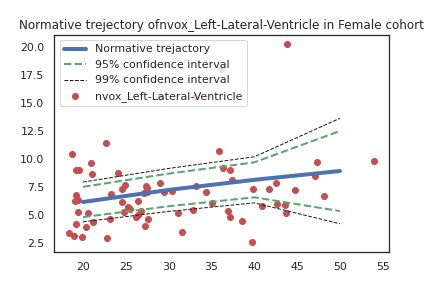

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


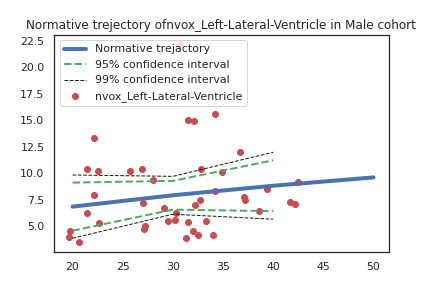

In [18]:
# plot a few regions with trajectories
trajectory_plotting(cov_forw, nm_dir)

In [27]:
# apply normative modeling to Patients
if not os.path.isfile(os.path.join(nm_dir,'Z_test.txt')): 
    pcn.normative.estimate(covfile = 'cov_norm.txt',
                        respfile = 'feat_norm.txt',
                        testcov = 'cov_test.txt',
                        testresp = 'feat_test.txt',
                        cvfolds = None,
                        alg = 'gpr',
                        outputsuffix = '_test',
                        param_inscale = None,
                        param_outscale = None)

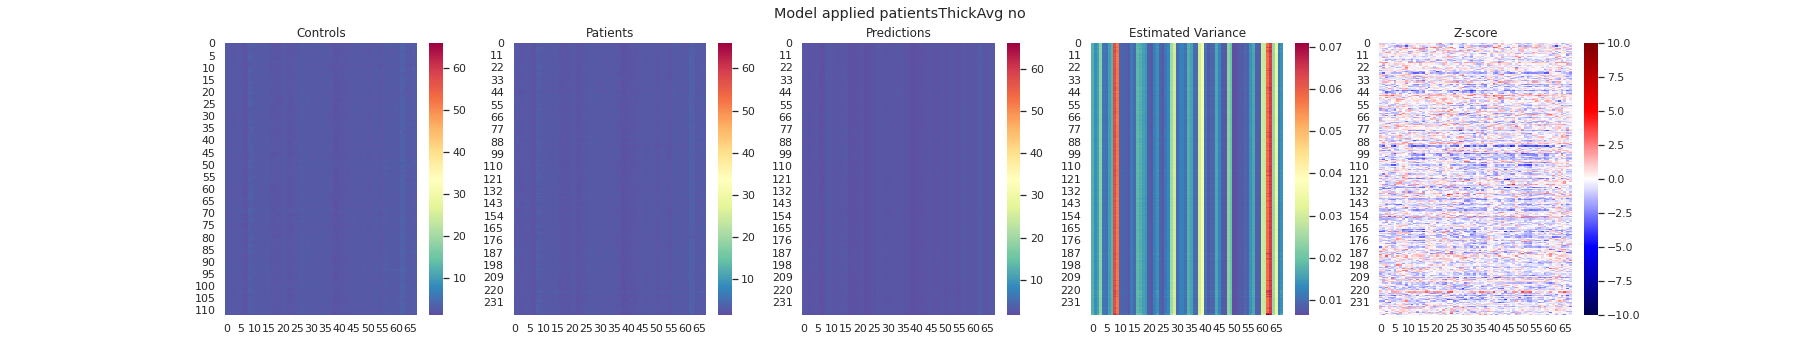

In [42]:
# Plot real and predicted values and estimated variance of the prediction
sns.set_style("white")
feat_norm = pd.read_csv(os.path.join(nm_dir,'feat_norm.txt'), sep=' ', header=None)
feat_test = pd.read_csv(os.path.join(nm_dir,'feat_test.txt'), sep=' ', header=None)
yhat_test = pd.read_csv(os.path.join(nm_dir,'yhat_test.txt'), sep=' ', header=None)
ys2_test = pd.read_csv(os.path.join(nm_dir,'ys2_test.txt'), sep=' ', header=None)
z_test = pd.read_csv(os.path.join(nm_dir,'Z_test.txt'), sep=' ', header=None)

#yhat = pd.read_csv(os.path.join(nm_dir,'yhat_10foldscale.txt'), sep=' ', header=None)
#ys2 = pd.read_csv(os.path.join(nm_dir,'ys2_10foldscale.txt'), sep=' ', header=None)

rtop = np.ceil(np.max([feat_norm.max().max(),yhat.max().max()]))

fig, axes = plt.subplots(1,5,figsize=(25, 5))

sns.heatmap(data=feat_norm, ax=axes[0], cbar=True, cmap='Spectral_r', vmax=rtop)
axes[0].set_title('Controls')
sns.heatmap(data=feat_test, ax=axes[1], cbar=True, cmap='Spectral_r', vmax=rtop)
axes[1].set_title('Patients')
sns.heatmap(data=yhat_test, ax=axes[2], cbar=True, cmap='Spectral_r', vmax=rtop)
axes[2].set_title('Predictions')
sns.heatmap(data=ys2_test, ax=axes[3], cbar=True, cmap='Spectral_r')
axes[3].set_title('Estimated Variance')
sns.heatmap(data=z_test, ax=axes[4], vmax=10, vmin = -10, cbar=True, cmap='seismic')
axes[4].set_title('Z-score')

fig.suptitle('Model applied patients'+fs_var + ' ' + transformation)

plt.show()

fig.savefig(os.path.join(images_dir, ('05_heat' + fs_var + '_'+transformation+'.png')))

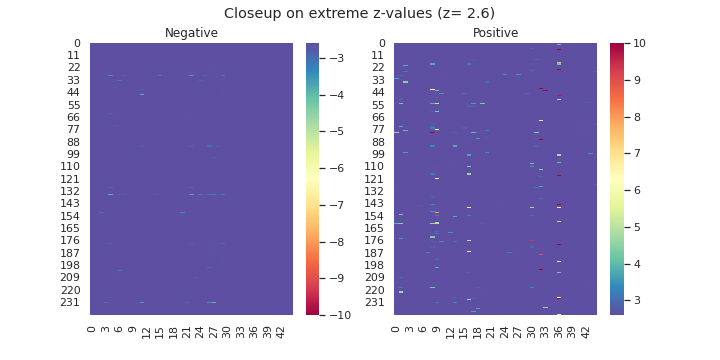

In [21]:
fig, axes = plt.subplots(1,2,figsize=(10, 5))
thresh = 2.6
sns.heatmap(data=z_test, ax=axes[0], cbar=True, cmap='Spectral',  vmax=-thresh, vmin= -10) #z: 2.6 == p:0.005
axes[0].set_title('Negative')
sns.heatmap(data=z_test, ax=axes[1], cbar=True, cmap='Spectral_r', vmin = thresh, vmax = 10)
axes[1].set_title('Positive')

fig.suptitle('Closeup on extreme z-values (z= ' + str(thresh)+')')
fig.savefig(os.path.join(images_dir, ('06_heat_z_' + fs_var + '_'+transformation+'.png')))

Deviations of patients from normative model
-------------------------------------------

In [46]:
# Extreme positive deviations of patients
pk = dk_roi_viz(nm_dir, z_estimate, 2, 'pos', fs_var)

if 'IC' in fs_var:
    plot_subcortical(array_name=pk, size=(800, 400),
                 cmap='Spectral_r', color_bar=True,
                 interactive=False,
                 embed_nb=True,
                 screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'07_3d_patients_pos_'+fs_var+'_'+transformation+'.png'))
else:
    plot_cortical(array_name=pk, surface_name="fsa5", size=(800, 400),
                cmap='Spectral_r', color_bar=True,
                interactive=False,
                embed_nb=True,
                screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'07_3d_patients_pos_'+fs_var+'_'+transformation+'.png'))



In [45]:
# Extreme negative deviations of patients
pk = dk_roi_viz(nm_dir, z_test, 2, 'neg', fs_var)

if 'IC' in fs_var:
    plot_subcortical(array_name=pk, size=(800, 400),
                 cmap='Spectral_r', color_bar=True,
                 interactive=False,
                 embed_nb=True,
                 screenshot=True,
                 transparent_bg = False,
                 filename=os.path.join(images_dir,'07_3d_patients_neg_'+fs_var+'_'+transformation+'.png'))
else:
    plot_cortical(array_name=pk, surface_name="fsa5", size=(800, 400),
                cmap='Spectral_r', color_bar=True,
                interactive=False,
                embed_nb=True,
                screenshot=True,
                transparent_bg = False,
                filename=os.path.join(images_dir,'07_3d_patients_neg_'+fs_var+'_'+transformation+'.png'))
